# Clusterlogs Notebook

In [1]:
import pandas as pd
from clusterlogs import pipeline, cluster_output
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /eos/user/l/lclissa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1. Download data from file and create pandas DataFrame with index 

In [2]:
df = pd.read_csv('../fts_mess_panda.csv', index_col=0).set_index('id')

In [2]:
%%time

# start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("fts_clustering").getOrCreate()
#spark = SparkSession.builder.master("local[*]").appName("fts_data").getOrCreate()
spark

CPU times: user 40.4 ms, sys: 26.3 ms, total: 66.7 ms
Wall time: 9.34 s


In [5]:
%%time 

# FTS data path
path_list = ['/project/monitoring/archive/fts/raw/complete/2019/10/{:0>2}/*'.format(i) for i in range(7,11)]

# load the data in the json file
all_transfers = spark.read.json(path_list)

# retrieve just data 
all_transfers_data = all_transfers.select("data.*")

errors = all_transfers_data.select("t__error_message", "t_final_transfer_state_flag").filter(all_transfers_data["t_final_transfer_state_flag"] == 0)

CPU times: user 267 ms, sys: 79.5 ms, total: 346 ms
Wall time: 4min 1s


In [6]:
error_freq = errors.groupBy("t__error_message").count()
error_freq = error_freq.orderBy(error_freq["count"].desc())

df = error_freq.toPandas()
df.head()

t__error_message   count
0  TRANSFER  globus_ftp_client: the server respon...  570137
1  TRANSFER  globus_ftp_control: gss_init_sec_con...  324553
2  Error on XrdCl::CopyProcess::Run(): [ERROR] Se...  224141
3  DESTINATION SRM_PUT_TURL error on the turl  re...  115402
4  TRANSFER  an end-of-file was reached globus_xi...  113417

In [4]:
df.head()

message  count
id                                                          
1   DESTINATION MAKE_PARENT srm-ifce err: Permissi...     27
2   TRANSFER  globus_ftp_client: the server respon...   1467
3   TRANSFER  globus_ftp_client: the server respon...      2
4   TRANSFER  globus_ftp_client: the server respon...     34
5   TRANSFER  globus_ftp_client: the server respon...      9

In [5]:
df.shape

(22792, 2)

### 2. Initialize clusterization pipeline

In [6]:
target = 'message'
# target = 't__error_message'

In [7]:
clustering_parameters = {'tokenizer':'nltk',
                         'w2v_size': 200,
                         'w2v_window': 10,
                         'min_samples': 200}

In [8]:
cluster = pipeline.ml_clustering(df, target, cluster_settings=clustering_parameters, mode='create', model_name='fts_word2vec.model')

### 3. Execute clusterization pipeline

In [9]:
%%time

cluster.process()

CPU times: user 1min 25s, sys: 1.93 s, total: 1min 27s
Wall time: 55.4 s


In [10]:
cluster.w2v_size

200

### 4. Get clusters statistics

Clusters Statistics returns DataFrame with statistic for all clusters:
- "cluster_name" - name of a cluster
- "cluster_size" - number of log messages in cluster
- "pattern" - all common substrings in cluster messages
- "vocab" - all tokens in error messasges
- "vocab_length" - the length of cluster's vocabulary
- "mean_length" - average length of log messages in cluster
- "std_length" - standard deviation of length of log messages in cluster
- "mean_similarity" - average similarity of log messages in cluster
- "std_similarity" - standard deviation of similarity of log messages in cluster

In [11]:
output = cluster_output.Output(cluster.df, 
                               cluster.target, 
                               cluster.tokenizer, 
                               cluster.messages, 
                               cluster.cluster_labels)

In [12]:
stat = output.statistics()

In [13]:
stat_df = pd.DataFrame.from_dict(stat)

In [14]:
stat_df.shape

(17, 9)

In [15]:
pd.options.display.max_colwidth = -1

In [16]:
stat_df.sort_values(by='cluster_size', ascending=False)[['cluster_name',
                                                        'cluster_size',
                                                        'pattern',
                                                        'mean_similarity']].head(30)

cluster_name  cluster_size  \
2   1            6467           
0   -1           4314           
6   5            2357           
1   0            1886           
4   3            1325           
9   8            1283           
10  9            1261           
8   7            749            
15  14           530            
5   4            422            
3   2            407            
11  10           371            
14  13           331            
13  12           322            
12  11           313            
7   6            228            
16  15           226            

                                                                                                                                                                                                                                                                       pattern  \
2   TRANSFER  globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3009] Unable to get free physical space /ek; No space left on device                                                            
0                                                                                                                                                                                                                                                                                
6   TRANSFER  globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3021] Unable to get quota space - quota not defined or exhausted /eos/cms/store/ngng-Dx                                         
1   DESTINATION MAKE_PARENT srm-ifce err: Permission denied, err: [SE][Mkdir][SRM_AUTHORIZATION_FAILURE] httpg://recas-se-01.cs.infn.it:8446/srm/managerv2: srm://recas-se-01.cs.infn.it/dpm/cs.infn.it/home/atlas/atlasdatadisk/rucio/user/: Permission denied                  
4   TRANSFER  globus_ftp_client: the server responded with an error 451 General problem: Failed to connect 1.:: Connection timed out                                                                                                                                             
9   TRANSFER  globus_ftp_client: the server responded with an error 451 451-GlobusError: v=1 c=INTERNAL_ERROR  451-GridFTP-Errno: 255  451-GridFTP-Reason: System error in write into HDFS (host=gftp.hep.kbfi.ee, user=cms, path=/cms/store/g: Unknown error 255  451 End.      
10  SOURCE CHECKSUM MISMATCH User defined checksum and source checksum do not match  !=                                                                                                                                                                                          
8   TRANSFER CHECKSUM MISMATCH USER_DEFINE and SRC checksums are different.  !=                                                                                                                                                                                                  
15  TRANSFER  globus_ftp_client: the server responded with an error 451 Failed to deliver PoolMgrSelectWritePoolMsg message <15744626> to [SpaceManager@local:>PoolManager@local]: Route for >*@dCacheDomain< not found at >spacemanagerDomain<                                  
5   Error reported from srm_ifce : 2 [SE][Ls][SRM_INVALID_PATH] No such file or directory /                                                                                                                                                                                      
3   TRANSFER  globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio: Unable to connect to   500-globus_xio: System error in connect: Connection timed out  500-globus_xio: A system call failed: Connection timed out  500 End.             
11  TRANSFER  globus_ftp_client: the server responded with an error 530 Login failed: Failed to deliver LoginMessage mes

Clusters with single value - outliers

In [40]:
stat_df[stat_df['cluster_name']=="1"]['pattern']

2    TRANSFER  globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3009] Unable to get free physical space /ek; No space left on device    
Name: pattern, dtype: object

### Timings for all stages of clusterization pipeline

process - timing of all process

In [17]:
cluster.timings

{'data_preparation': 0.6192,
 'tokenization': 6.6592,
 'tokens_vectorization': 9.3307,
 'sentence_vectorization': 6.643,
 'kneighbors': 27.0818,
 'epsilon_search': 0.1712,
 'dbscan': 4.9184,
 'process': 55.4237}

### Get all error messages in single cluster

##### Outliers 

In [20]:
from random import sample
from termcolor import colored

n_mess_to_show = 50
print( colored("Outliers cluster\n", 'red'))

messages = sample(output.in_cluster(-1),n_mess_to_show)
for idx, mess in enumerate(messages):
    print(colored("\n{}.".format(idx+1),'blue'), mess)

Outliers cluster


1. DESTINATION SRM_PUT_TURL error on the turl request : [SE][UID][SRM_INTERNAL_ERROR] error accessing dpm02.reef.man.poznan.pl:/mnt/storage/dpm0201/atlas/2019-11-22: Timed out

2. DESTINATION SRM_PUTDONE Error on the surl srm://srm.grid.sara.nl/pnfs/grid.sara.nl/data/atlas/UID/rucio/mc16_13TeV/24/fc/DAOD_TOPQ5.19542826._000967.pool.root.1 while putdone : [SE][PutDone][SRM_INVALID_PATH] SURL is not local: srm://srm.grid.sara.nl/pnfs/grid.sara.nl/data/atlas/UID/rucio/mc16_13TeV/24/fc/DAOD_TOPQ5.19542826._000967.pool.root.1

3. DESTINATION SRM_PUT_TURL error on the turl request : [SE][UID][SRM_INVALID_PATH] Failed to put /storage/data/cms/store/mc/UID/WToMuNu_M-200_TuneCP5_13TeV-pythia8/MINIAODSIM/102X_upgrade2018_realistic_v15-v1/100000/EE2745DB-57D7-CA44-AA38-UID.root

4. TRANSFER globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio: Unable to connect to 2A0E:E140::182:24263 500-globus_xio: System error in connect: No route to hos

##### Other clusters 

In [21]:
from termcolor import colored

n_mess_to_show = 15
for clust_id in range(stat_df.shape[0]):

    print( colored("\n\nCluster n.{}: {}\n".format(clust_id, stat_df[stat_df['cluster_name']==str(clust_id)]['pattern']), 'red'))
    for idx, mess in enumerate(output.in_cluster(clust_id)[:n_mess_to_show]):
        print(colored("{}.".format(idx+1),'blue'), mess)



Cluster n.0: 1    DESTINATION MAKE_PARENT srm-ifce err: Permission denied, err: [SE][Mkdir][SRM_AUTHORIZATION_FAILURE] httpg://recas-se-01.cs.infn.it:8446/srm/managerv2: srm://recas-se-01.cs.infn.it/dpm/cs.infn.it/home/atlas/atlasdatadisk/rucio/user/: Permission denied 
Name: pattern, dtype: object

1. DESTINATION MAKE_PARENT srm-ifce err: Permission denied, err: [SE][Mkdir][SRM_UID_FAILURE] httpg://recas-se-01.cs.infn.it:8446/srm/managerv2: srm://recas-se-01.cs.infn.it/dpm/cs.infn.it/home/atlas/UID/rucio/user/lxu/76/98: Permission denied
2. DESTINATION MAKE_PARENT srm-ifce err: Permission denied, err: [SE][Mkdir][SRM_UID_FAILURE] httpg://recas-se-01.cs.infn.it:8446/srm/managerv2: srm://recas-se-01.cs.infn.it/dpm/cs.infn.it/home/atlas/UID/rucio/user/lxu/a6/bb: Permission denied
3. DESTINATION MAKE_PARENT srm-ifce err: Permission denied, err: [SE][Mkdir][SRM_UID_FAILURE] httpg://recas-se-01.cs.infn.it:8446/srm/managerv2: srm://recas-se-01.cs.infn.it/dpm/cs.infn.it/home/atlas/UID/rucio

1. TRANSFER globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio: Unable to connect to 2001:2F8:102D:589:2:3:1:101:21378 500-globus_xio: System error in connect: Connection timed out 500-globus_xio: A system call failed: Connection timed out 500- 500 End.
2. TRANSFER globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio: Unable to connect to 2001:660:530F:5:193:48:83:145:24856 500-globus_xio: System error in connect: Connection timed out 500-globus_xio: A system call failed: Connection timed out 500- 500 End.
3. TRANSFER globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio: Unable to connect to 2001:660:3036:197:134:158:159:36:22321 500-globus_xio: System error in connect: Connection timed out 500-globus_xio: A system call failed: Connection timed out 500- 500 End.
4. TRANSFER globus_ftp_client: the server responded with an error 500 500-Command failed. : globus_xio: Unable 

##### Tokens cloud 

In [22]:
cluster_documents = []

for clust_id in range(stat_df.shape[0]):
    cluster_documents.append(output.in_cluster(clust_id-1))

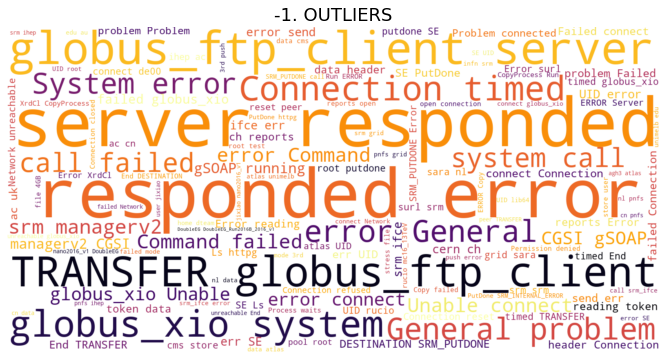

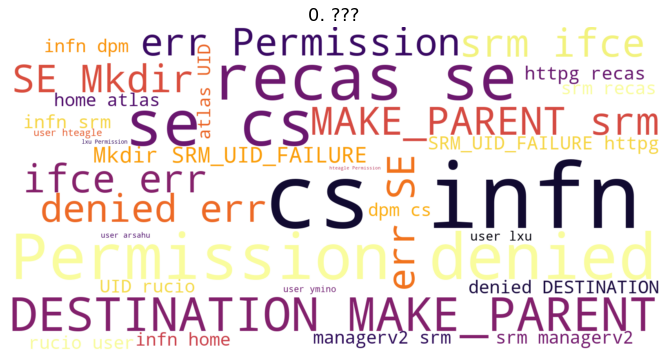

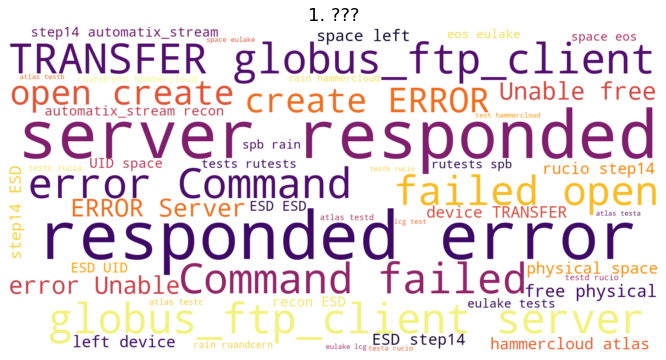

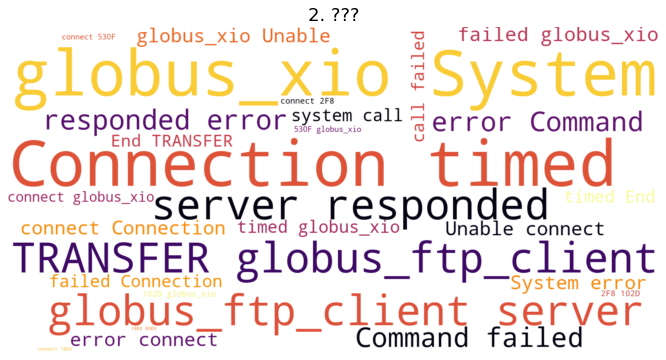

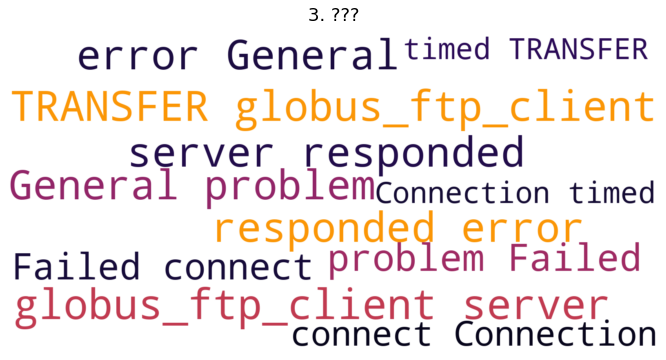

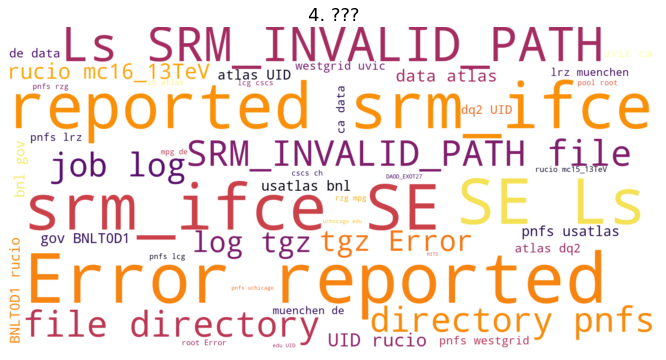

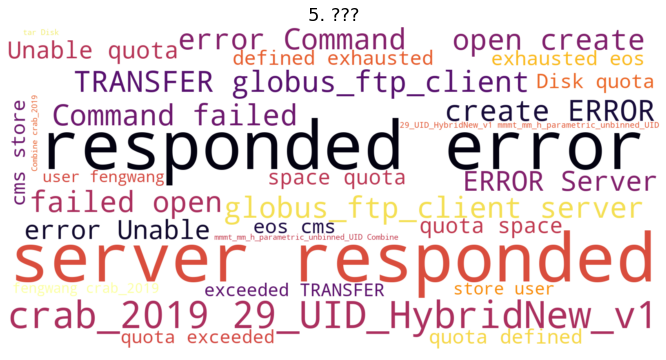

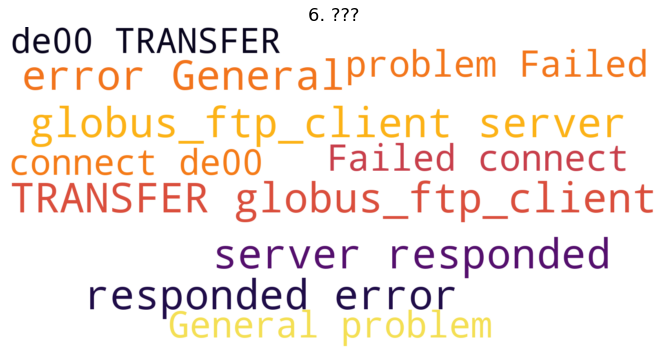

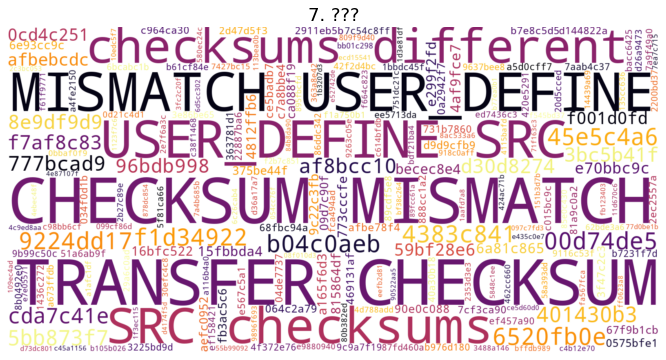

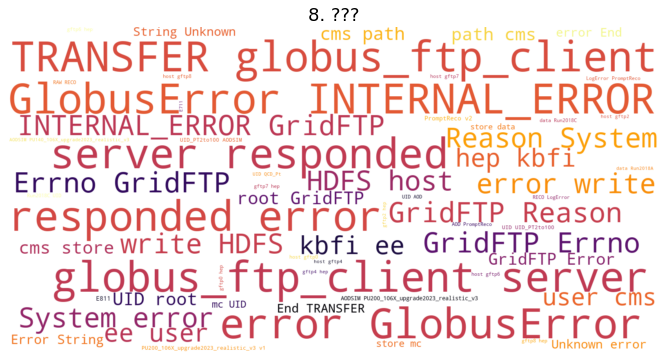

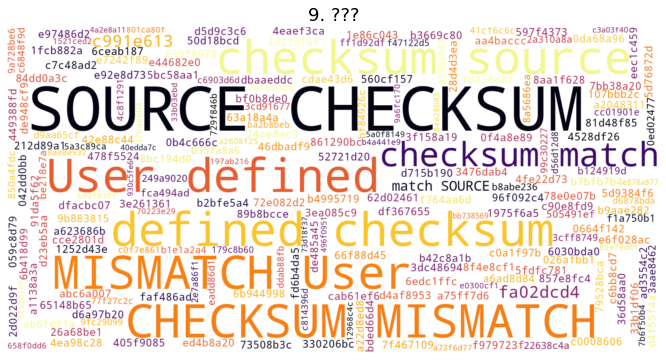

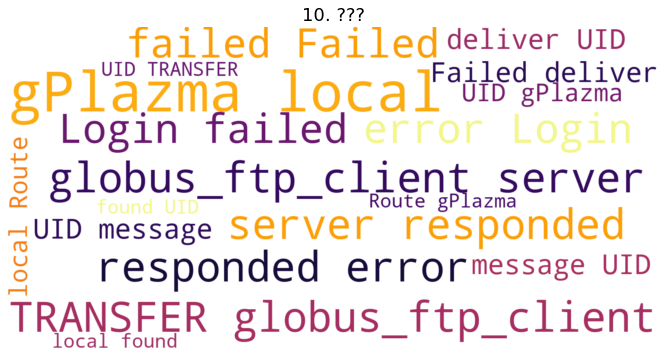

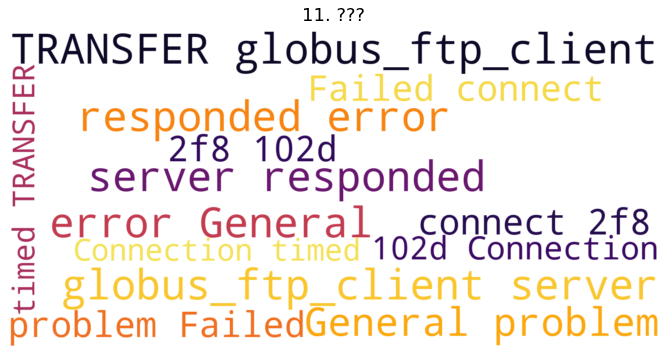

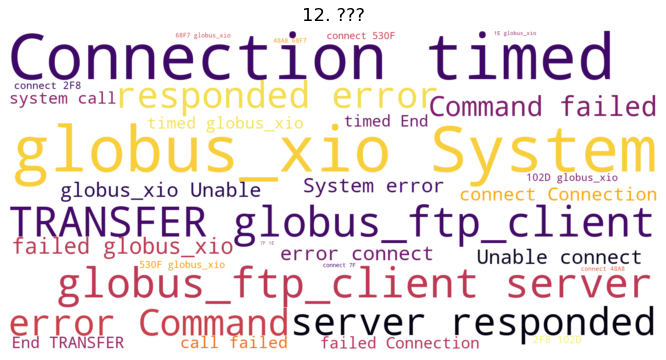

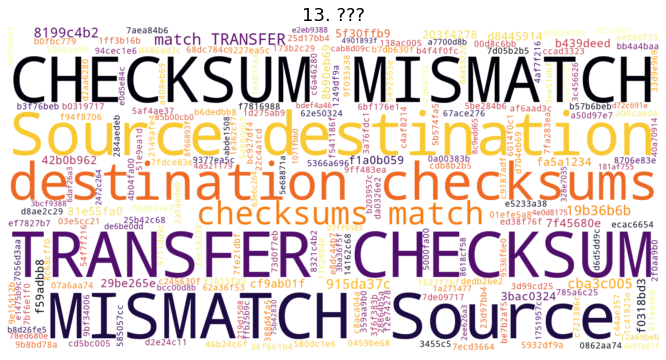

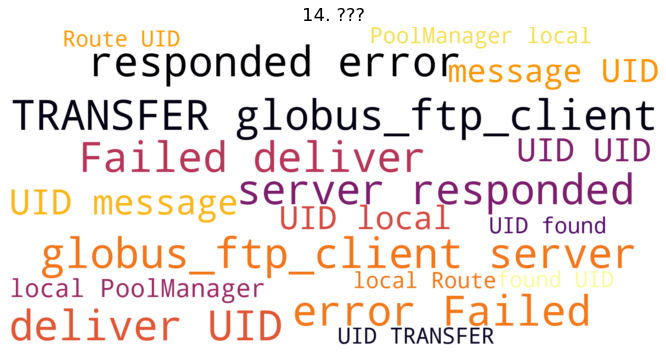

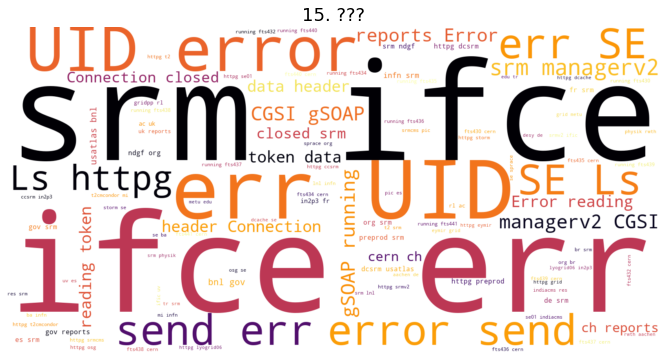

In [23]:
from pathlib import Path
import matplotlib
from matplotlib import pyplot as plt 
import seaborn as sns

import wordcloud as wdcld

sns.set_context("paper", rc={"axes.titlesize":18,"axes.labelsize":22})

descriptions = {label-1: "???" for label in range(stat_df.shape[0])}
descriptions[-1] = "Outliers"

results_folder = "test_comparison"

results_path = Path('''/eos/user/l/lclissa/SWAN_projects/fts-errors-clustering/
                        notebooks/results/{}/tokenclouds_dbscan'''.format(results_folder))
results_path.mkdir(parents=True, exist_ok=True)

for clust_id in range(stat_df.shape[0]):
    # Create and generate a word cloud image:
    wordcloud = wdcld.WordCloud(width=1600, height=800, background_color="white", min_font_size=11, 
                                colormap=matplotlib.cm.inferno).generate(' '.join(cluster_documents[clust_id]))

    # Display the generated image:
    fig = plt.figure(figsize=(12,6))
    plt.title("{}. {}".format(clust_id-1, descriptions[clust_id-1].upper()))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    output_path = results_path / "Cluster_n{}_with_description.png".format(clust_id-1)
    fig.savefig(output_path, format=str(output_path).split(".")[-1], bbox_inches='tight')

##### RANDOM TESTS

In [46]:
import difflib
def matcher(strings):
    """
    Find all matching blocks in a list of strings
    :param strings:
    :return:
    """
    curr = strings[0]
    if len(strings) == 1:
        return curr
    else:
        cnt = 1
        for i in range(cnt, len(strings)):
            matches = difflib.SequenceMatcher(None, curr, strings[i])
            common = []
            for match in matches.get_matching_blocks():
                common.append(curr[match.a:match.a + match.size])
            curr = ''.join(common)
            cnt = cnt + 1
            if cnt == len(strings):
                break
        if curr == '':
            'NO COMMON PATTERNS HAVE BEEN FOUND'
        return curr

In [51]:
mess_list = output.in_cluster(3)[:10]
mess_list

['TRANSFER globus_ftp_client: the server responded with an error 451 General problem: Failed to connect 158.195.14.22:24905: Connection timed out',
 'TRANSFER globus_ftp_client: the server responded with an error 451 General problem: Failed to connect 158.195.14.25:23347: Connection timed out',
 'TRANSFER globus_ftp_client: the server responded with an error 451 General problem: Failed to connect 158.195.14.8:20962: Connection timed out',
 'TRANSFER globus_ftp_client: the server responded with an error 451 General problem: Failed to connect 158.195.14.19:23485: Connection timed out',
 'TRANSFER globus_ftp_client: the server responded with an error 451 General problem: Failed to connect 158.195.14.25:23813: Connection timed out',
 'TRANSFER globus_ftp_client: the server responded with an error 451 General problem: Failed to connect 158.195.14.21:21624: Connection timed out',
 'TRANSFER globus_ftp_client: the server responded with an error 451 General problem: Failed to connect 158.195.1

In [52]:
matcher(mess_list)

'TRANSFER globus_ftp_client: the server responded with an error 451 General problem: Failed to connect 158.195.14.:2: Connection timed out'

### Output clusters - mode == 'ALL'  (for cluster '2')

In [28]:
output.clustered_output(mode='ALL')['1']

[{'message': 'TRANSFER  globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3009] Unable to get free physical space /eulake/lcg/test/hammercloud/atlas/testd/rucio/step14/ESD/693/step14.61955.automatix_stream.recon.ESD.693/ESD.74fb7fa5cf0a434488ee76892f7086e2; No space left on device    ',
  'count': 2,
  'cluster': 1},
 {'message': 'TRANSFER  globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3009] Unable to get free physical space /eos/eulake/tests/rutests/spb/rain/hammercloud/atlas/testa/rucio/step14/ESD/22/step14.68507.automatix_stream.recon.ESD.22/ESD.d4594fd3f73741d59cd71fb773816da3; No space left on device    ',
  'count': 34,
  'cluster': 1},
 {'message': 'TRANSFER  globus_ftp_client: the server responded with an error 500 Command failed. : open/create : [ERROR] Server responded with an error: [3009] Unable to get free phy

### Output clusters - mode == 'INDEX' (for cluster '2')

In [172]:
output.clustered_output(mode='INDEX')['1']

[2]

### Output clusters - mode == 'TARGET' (for cluster '2')

In [173]:
output.clustered_output(mode='TARGET')['1']

['TRANSFER  globus_ftp_client: the server responded with an error 500 Command failed. : IPC failed while attempting to perform request   ']

### Output clusters - cluster labels

In [87]:
cluster.cluster_labels

array([ 0,  1,  2, ..., 16, 76,  5])

### Get epsilon value (which was used in DBSCAN algorithm)

In [36]:
cluster.epsilon

0.0492865756267671